In [1]:
import pandas as pd

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
rna_seq_df = pd.read_csv('medians.csv',sep=',')
rna_seq_df

#The first row lists the cluster name (cluster_label), which matches the cell type alias shown in the Transcriptomic Explorer.
#The first column lists the unique gene identifier (gene), which in most cases is the gene symbol.

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_2,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,0.000000,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,0.313972,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45763,n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45764,n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45765,n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
45766,n-R5s146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [3]:
rna_seq_columns = list(rna_seq_df.columns)

In [4]:
# make a list of genes containing Sema, Dbn, Ulk, and Cdkl
selected_genes = []

for gene in rna_seq_df['Unnamed: 0']:
    if 'Sema' in gene:
        selected_genes.append(gene)
    elif 'Dbn' in gene:
        selected_genes.append(gene)
    elif 'Ulk' in gene:
        selected_genes.append(gene)
    elif 'Cdkl' in gene:
        selected_genes.append(gene)

print(selected_genes)
print(len(selected_genes))

['Cdkl1', 'Cdkl2', 'Cdkl3', 'Cdkl4', 'Cdkl5', 'Dbn1', 'Dbndd1', 'Dbndd2', 'Dbnl', 'Sema3a', 'Sema3b', 'Sema3c', 'Sema3d', 'Sema3e', 'Sema3f', 'Sema3g', 'Sema4a', 'Sema4b', 'Sema4c', 'Sema4d', 'Sema4f', 'Sema4g', 'Sema5a', 'Sema5b', 'Sema6a', 'Sema6b', 'Sema6c', 'Sema6d', 'Sema7a', 'Ulk1', 'Ulk2', 'Ulk3', 'Ulk4']
33


In [5]:
# helper method to keep certain genes in the dataframe
def has_sel_genes(string):
    '''
    returns True if the row is one of the selected genes
    '''
    if string in selected_genes:
        return True
    else:
        return False

In [6]:
# makes a new columns 'selected' of T/F values depending
# on if value of the row in 'Unnamed: 0' is == a name in the list of selected genes
rna_seq_df['selected'] = rna_seq_df['Unnamed: 0'].apply(has_sel_genes)
rna_seq_df

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
0,0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
1,0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
2,0610007P14Rik,6.600176,6.813337,6.704629,6.668049,6.773956,6.362829,6.691099,6.708878,7.162359,...,6.974747,0.000000,5.633328,0.0,0.0,0.0,0.0,0.000000,0.0,False
3,0610009B22Rik,6.169217,6.473920,6.314496,6.533899,6.450335,6.585420,6.825147,6.757542,6.932700,...,7.104814,6.486057,6.576098,0.0,0.0,0.0,0.0,5.304603,0.0,False
4,0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45763,n-R5s142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
45764,n-R5s143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
45765,n-R5s144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False
45766,n-R5s146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,False


In [7]:
# keep all the rows that have the selected genes
rna_seq_sel_df = rna_seq_df[rna_seq_df['selected'] == True]
rna_seq_sel_df

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,VLMC_3,VLMC_4,VLMC_5,Endo_1,Endo_2,Endo_3,SMC,Macrophage_1,Macrophage_2,selected
4982,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
4983,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
4984,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,1.424641,0.000000,0.000000,0.000000,0.588994,1.511518,0.733835,0.000000,0.816241,True
4985,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
4986,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
6403,Dbn1,5.884859,6.248792,6.055806,5.781213,5.931662,6.311197,5.906324,5.552831,5.855709,...,1.121161,0.000000,4.569990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
6404,Dbndd1,4.923385,4.498263,3.994455,4.643698,5.137957,4.973848,5.162447,5.210099,4.619636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
6405,Dbndd2,6.233497,6.292110,6.338248,5.735836,5.706241,5.338789,5.374433,5.794300,4.134198,...,0.666856,0.000000,6.793721,0.000000,0.000000,7.628894,8.553760,0.000000,0.000000,True
6406,Dbnl,6.582157,6.124791,6.057062,6.328222,6.495780,6.320555,6.588634,6.534042,6.314592,...,1.927132,0.000000,1.380166,0.000000,0.000000,0.000000,0.536307,6.955108,0.000000,True
40041,Sema3a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.911743,4.000524,5.992039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True


Take first 93 columns - those are all the GABAergic cells according to https://celltypes.brain-map.org/rnaseq/mouse/cortex-and-hippocampus. GABAergic are inhibitory

In [8]:
gaba_cells = rna_seq_columns[:92]
# use reset_index to make it easier to iterate over the rows in a for loop
# using reset_index makes a new column 'index' containing the old indexes -- we get rid of this column using .drop()
inhib_df = rna_seq_sel_df[gaba_cells].reset_index().drop(columns = 'index')
inhib_df

,Unnamed: 0,Lamp5_1,Lamp5_2,Lamp5_3,Lamp5_4,Lamp5_5,Lamp5_6,Lamp5 Lhx6_1,Lamp5 Lhx6_2,Lamp5 Lhx6_3,...,Pvalb_6,Pvalb_7,Pvalb_8,Pvalb_9,Pvalb_10,Pvalb_11,Pvalb_12,PIR Six3,Meis2_1,Meis2_2
0,Cdkl1,1.670675,0.000000,0.000000,0.000000,0.541351,0.000000,0.977317,1.319980,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.791623,0.000000,0.000000,0.000000,0.000000
1,Cdkl2,5.420624,4.870091,5.253918,5.453987,4.985667,4.911397,5.054950,4.828364,4.543412,...,3.916947,2.562382,3.496243,4.322920,4.198744,4.739886,4.416626,0.000000,0.000000,0.000000
2,Cdkl3,2.916650,0.907853,0.566943,1.025745,2.109809,1.927891,3.949376,4.095468,2.946028,...,4.590873,4.538678,4.529392,4.727894,2.316425,4.583128,4.790623,1.056769,0.000000,0.000000
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Cdkl5,7.351030,7.288644,7.195835,7.482002,7.339962,6.789152,6.819178,5.966889,5.932333,...,5.393745,5.927515,5.977744,6.103331,5.774603,6.552572,7.252677,2.702816,2.117104,0.000000
5,Dbn1,5.884859,6.248792,6.055806,5.781213,5.931662,6.311197,5.906324,5.552831,5.855709,...,5.212140,5.266657,5.294274,5.492144,5.512485,5.499944,5.438812,2.856988,4.131451,0.000000
6,Dbndd1,4.923385,4.498263,3.994455,4.643698,5.137957,4.973848,5.162447,5.210099,4.619636,...,4.689130,4.583539,4.641292,4.624529,3.919324,5.082920,4.923056,0.000000,0.000000,0.000000
7,Dbndd2,6.233497,6.292110,6.338248,5.735836,5.706241,5.338789,5.374433,5.794300,4.134198,...,5.105394,4.614793,5.136253,4.235900,4.699248,5.254595,5.657329,6.760008,0.000000,0.000000
8,Dbnl,6.582157,6.124791,6.057062,6.328222,6.495780,6.320555,6.588634,6.534042,6.314592,...,6.448647,6.181501,6.262014,6.153462,5.818519,6.119585,6.077106,0.000000,0.000000,0.000000
9,Sema3a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.270020,0.000000,4.359028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Take first 93-271 columns - those are all the glutamatergic cells

In [9]:
glut_cells_noname = rna_seq_columns[93:271]
glut_cells = ['Unnamed: 0'] + glut_cells_noname
# add column with names of gene
excit_df = rna_seq_sel_df[glut_cells].reset_index().drop(columns = 'index')
excit_df

,Unnamed: 0,DG_1,DG_2,DG_3,RSP/ACA L4/5 IT_1,L2/3 IT Cxcl14_1,L2/3 IT Cxcl14_2,L2/3 IT Cxcl14_3,L2/3 IT Cxcl14_4,L2/3 IT Cxcl14_5,...,CA1sp_9,CA1sp_10,CA3sp_1,CA3sp_2,CA3sp_3,CA3sp_4,CA3sp_5,CA3sp_6,CA3sp_7,CA2sp/IG
0,Cdkl1,0.000000,0.000000,3.746670,5.012364,0.000000,4.937156,0.000000,1.373728,0.000000,...,3.418546,0.000000,0.000000,3.152502,1.448265,3.306766,0.000000,1.635995,2.703161,0.666196
1,Cdkl2,0.000000,0.000000,5.334057,5.109621,0.000000,4.357947,1.491599,0.000000,0.738046,...,5.878004,5.902738,5.722776,5.855889,5.718631,5.807811,5.058910,5.547935,6.077206,6.415570
2,Cdkl3,0.000000,1.423622,4.252210,2.447258,0.000000,0.000000,1.437999,0.000000,0.000000,...,3.582957,1.531994,0.000000,4.175457,3.534324,4.917072,2.853081,3.655033,3.542703,3.838813
3,Cdkl4,0.000000,0.000000,0.000000,0.000000,0.000000,4.015409,2.661053,0.000000,0.000000,...,3.675164,0.000000,0.000000,0.000000,0.000000,1.987449,0.000000,0.000000,0.000000,0.000000
4,Cdkl5,6.612175,4.636283,6.266611,8.374862,6.184964,6.972876,7.048049,7.068609,7.234053,...,5.895390,6.953117,5.812516,5.823663,6.139273,6.860827,7.063832,6.579482,5.833041,7.591199
5,Dbn1,6.568203,7.581335,7.789142,6.306225,1.347624,7.603625,6.940378,6.820229,5.652835,...,7.206650,7.720776,7.191686,7.575032,8.303897,7.954931,7.207551,7.243595,7.524596,7.322615
6,Dbndd1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.889517,0.000000,5.373673,5.266556,4.358908,0.000000
7,Dbndd2,6.874906,7.293015,7.025902,5.305219,5.725133,6.551575,6.791829,6.258440,3.319466,...,6.545631,6.915377,6.690501,6.718218,6.863337,6.692295,6.729236,7.088597,6.966374,6.993469
8,Dbnl,0.000000,6.211988,6.126955,4.093923,4.582900,6.163680,4.735616,5.027365,0.000000,...,6.974984,6.806542,6.575474,6.602852,6.759839,6.935379,6.080953,6.396573,6.790945,6.358093
9,Sema3a,0.000000,0.000000,0.000000,5.129395,0.000000,0.000000,0.000000,3.462667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


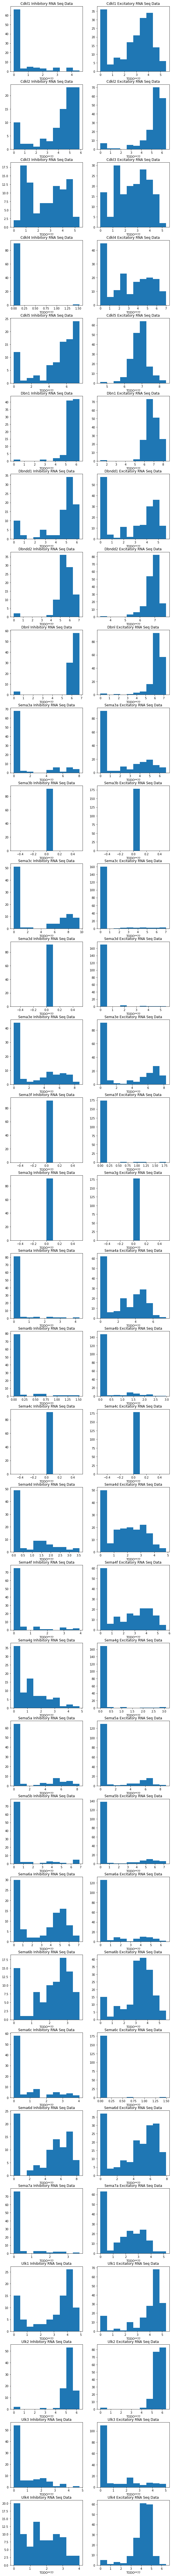

In [46]:
# exploratory analysis checking distributions of inhib and excitatory for each gene
# TODO: what label do i put for the xaxes?
fig, ax = plt.subplots(num_genes, 2, figsize=(10, 165))
num_genes = len(inhib_df)

for i in range(num_genes):
    # plot inhibitory data on left
    ax[i,0].hist(inhib_df.iloc[i][1:])
    ax[i,0].set_xlabel('TODO**??')
    ax[i,0].set_title(inhib_df.loc[i][0] + ' Inhibitory RNA Seq Data')

    # plot excitatory data on right
    ax[i,1].hist(excit_df.iloc[i][1:])
    ax[i,1].set_xlabel('TODO**??')
    ax[i,1].set_title(excit_df.loc[i][0] + ' Excitatory RNA Seq Data')

plt.show()

see if the median is differen between excitiatryo and inhibitory
each column is a unique neuron
treat each column as a different trial as the cell
10 indiviidual t tests for reach gene

do t_test of each row - inhib vs exictaty

In [33]:
def ttest_stats(index_of_gene):
    '''
    returns ttest results of exitatory df and inhib df of a gene at a specific index
    inputs: index number of gene
    '''
    return stats.ttest_ind(excit_df.iloc[index_of_gene][1:], inhib_df.iloc[index_of_gene][1:])   

In [34]:
for i in range(len(inhib_df)):
    gene_name = inhib_df['Unnamed: 0'][i]
    print(gene_name+ ': ' + str(ttest_stats(i)))

Cdkl1: Ttest_indResult(statistic=10.925950155995697, pvalue=3.2593111208095874e-23)
Cdkl2: Ttest_indResult(statistic=5.6625505637715765, pvalue=3.84817928687297e-08)
Cdkl3: Ttest_indResult(statistic=-0.6169377466173105, pvalue=0.5378015026320815)
Cdkl4: Ttest_indResult(statistic=12.804304957031604, pvalue=1.3765066962179346e-29)
Cdkl5: Ttest_indResult(statistic=10.19741273367746, pvalue=7.766911711147232e-21)
Dbn1: Ttest_indResult(statistic=13.170761863174636, pvalue=7.323732213717627e-31)
Dbndd1: Ttest_indResult(statistic=-6.4630591237244355, pvalue=4.848870038195967e-10)
Dbndd2: Ttest_indResult(statistic=14.405710116166306, pvalue=3.3461560939897725e-35)
Dbnl: Ttest_indResult(statistic=1.161840852570256, pvalue=0.24633764953605897)
Sema3a: Ttest_indResult(statistic=2.277195389949621, pvalue=0.023565760745270614)
Sema3b: Ttest_indResult(statistic=nan, pvalue=nan)
Sema3c: Ttest_indResult(statistic=-8.590636533927794, pvalue=7.337805754818575e-16)
Sema3d: Ttest_indResult(statistic=1.948

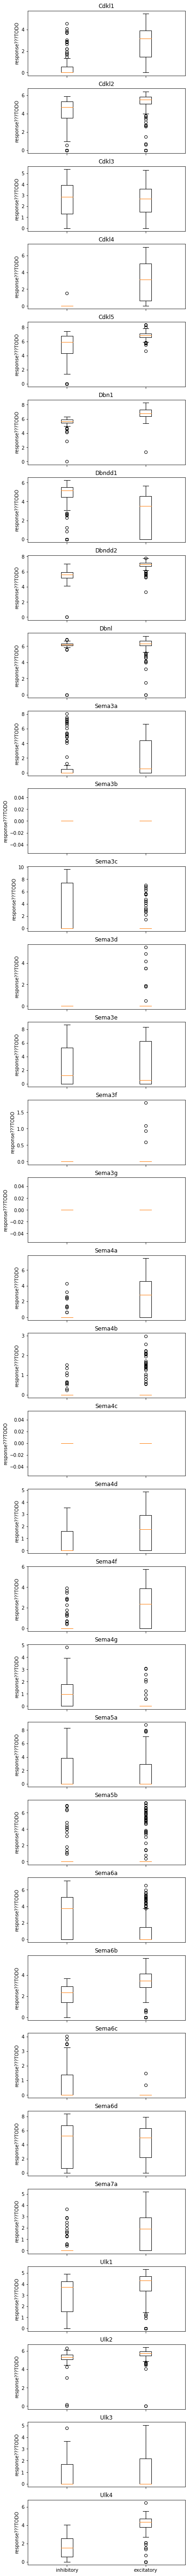

In [35]:
# for each gene, make a boxplot comparing inhib and exitatory
# TODO: how do i change the tick label for each indivual plot, and what should the Y axis label be?

num_genes = len(inhib_df)
fig, ax = plt.subplots(num_genes, 1, figsize=(6,100),sharex=True)
y_label = 'response???TODO'

for i in range(num_genes):  
    ax[i].boxplot([inhib_df.loc[i][1:], excit_df.loc[i][1:]])
    ax[i].set_title(inhib_df.loc[i][0])
    ax[i].set_ylabel(y_label)


plt.xticks([1,2],['inhibitory','excitatory'])
plt.show()